# Setting up the GDrive Path

In [0]:
import os
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
os.chdir('/content/gdrive/My Drive/AML')

In [0]:
os.getcwd()

'/content/gdrive/My Drive/AML'

In [0]:
!pip install catboost

In [0]:
!pip install xgboost

# Import libraries

In [0]:
# Import all libraries

import pandas as pd
from datetime import date, datetime, timedelta
import numpy as np

import catboost as cb
import xgboost as xgb
import lightgbm as lgb

from sklearn import model_selection
from sklearn import metrics
from sklearn import tree
from sklearn import ensemble
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score, train_test_split 
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import accuracy_score,make_scorer,fbeta_score

import Ndcg_scorer
from Ndcg_scorer import ndcg_score

import pickle

from sklearn import preprocessing
import operator
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier



# Custom-Functions

In [0]:
def sort_list(list1, list2): 
  
    zipped_pairs = zip(list2, list1) 
  
    z = [x for _, x in sorted(zipped_pairs,reverse = True)] 
      
    return z 

In [0]:
def split_data_frame_list(df, 
                       target_column,
                      output_type=float):
    ''' 
    Accepts a column with multiple types and splits list variables to several rows.

    df: dataframe to split
    target_column: the column containing the values to split
    output_type: type of all outputs
    returns: a dataframe with each entry for the target column separated, with each element moved into a new row. 
    The values in the other columns are duplicated across the newly divided rows.
    '''
    row_accumulator = []
    def split_list_to_rows(row):
        split_row = row[target_column]
        if isinstance(split_row, list):
          for s in split_row:
              new_row = row.to_dict()
              new_row[target_column] = s
              row_accumulator.append(new_row)
          if split_row == []:
              new_row = row.to_dict()
              new_row[target_column] = None
              row_accumulator.append(new_row)
        else:
          new_row = row.to_dict()
          new_row[target_column] = split_row
          row_accumulator.append(new_row)
    df.apply(split_list_to_rows, axis=1)
    new_df = pd.DataFrame(row_accumulator)
    return new_df

In [0]:
import numpy as np
from sklearn.preprocessing import LabelBinarizer


def dcg_score(y_true, y_score, k=5):
    """Discounted cumulative gain (DCG) at rank K.

    Parameters
    ----------
    y_true : array, shape = [n_samples]
        Ground truth (true relevance labels).
    y_score : array, shape = [n_samples, n_classes]
        Predicted scores.
    k : int
        Rank.

    Returns
    -------
    score : float
    """
    order = np.argsort(y_score)[::-1]
    
    y_true = np.take(y_true, order[:k])

    gain = 2 ** y_true - 1

    discounts = np.log2(np.arange(len(y_true)) + 2)
    return np.sum(gain / discounts)

def ndcg_score(ground_truth, predictions, k=5):
    """Normalized discounted cumulative gain (NDCG) at rank K.

    Normalized Discounted Cumulative Gain (NDCG) measures the performance of a
    recommendation system based on the graded relevance of the recommended
    entities. It varies from 0.0 to 1.0, with 1.0 representing the ideal
    ranking of the entities.

    Parameters
    ----------
    ground_truth : array, shape = [n_samples]
        Ground truth (true labels represended as integers).
    predictions : array, shape = [n_samples, n_classes]
        Predicted probabilities.
    k : int
        Rank.

    Returns
    -------
    score : float

    Example
    -------
    >>> ground_truth = [1, 0, 2]
    >>> predictions = [[0.15, 0.55, 0.2], [0.7, 0.2, 0.1], [0.06, 0.04, 0.9]]
    >>> score = ndcg_score(ground_truth, predictions, k=2)
    1.0
    >>> predictions = [[0.9, 0.5, 0.8], [0.7, 0.2, 0.1], [0.06, 0.04, 0.9]]
    >>> score = ndcg_score(ground_truth, predictions, k=2)
    0.6666666666
    """
    
    if not isinstance(ground_truth, list):
        ground_truth = ground_truth.tolist()
    if not isinstance(predictions,list):
        predictions = predictions.tolist()
        
    lb = LabelBinarizer()
    lb.fit(range(len(predictions) + 1))
    T = lb.transform(ground_truth)
    scores = []

    # Iterate over each y_true and compute the DCG score
    for y_true, y_score in zip(T, predictions):
        actual = dcg_score(y_true, y_score, k)
        
        #print(actual)
        best = dcg_score(y_true, y_true, k)
        score = float(actual) / float(best)
        scores.append(score)

    return np.mean(scores)

# Model building

### Load Final Processed Data

In [0]:
Data1 = pd.read_csv('FinalDataset1(NoDummy_NoMissingResolution).csv')

In [0]:
Data2 = pd.read_csv('FinalDataset2(Dummified_NoMissingResolution).csv')

In [0]:
Data3 = pd.read_csv('FinalDataset3(Dummified_MissingResolved).csv')

In [0]:
test_data1 = pd.read_csv('Test_Dataset1(NoDummy_NoMissingResolution).csv')

In [0]:
test_data2 = pd.read_csv('Test_Dataset2(Dummified_NoMissingResolution).csv')

In [0]:
test_data3 = pd.read_csv('Test_Dataset3(Dummified_NoMissingResolution).csv')

In [0]:
print(Data1.shape,Data2.shape,Data3.shape)
print(test_data1.shape,test_data2.shape,test_data3.shape)

(213451, 103) (213451, 164) (213451, 164)
(62096, 102) (62096, 164) (62096, 164)


In [0]:
#Data1.columns[np.invert(Data1.columns.isin(test_data1.columns))]

In [0]:
#test_data3.columns[np.invert(test_data3.columns.isin(test_data2.columns))]

# Model 1 - Decision tree


In [0]:
# Preprocessing :

le = preprocessing.LabelEncoder()
le.fit(["NDF", "US", "other","FR","IT","GB","ES","CA","DE","NL","AU","PT"])
df_2 = Data3
df_2['country_destination'] = le.transform(df_2['country_destination'])

## Test Train Split 

In [0]:
columns_x = list(df_2.columns)
columns_x.remove('country_destination')
X = df_2[columns_x]
y = df_2['country_destination']

In [0]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=45, stratify = y)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2222, random_state= 45, stratify = y_train)

## Basic Decision Tree

In [0]:
clf = DecisionTreeClassifier(random_state=45)
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_val)
print("Accuracy score on validation split of basic decision tree:",metrics.accuracy_score(y_val, y_pred))


Accuracy score on validation split of basic decision tree: 0.5051539146324322


##  Decision Tree with tuned depth parameter

In [0]:
# Iterating with depth from 1 to 32

max_depths = range(3,15)
train_results = []
test_results = []
dt_estimator = tree.DecisionTreeClassifier()

print('Decision tree with changing depths')
for max_depth in max_depths:
    dt = tree.DecisionTreeClassifier(max_depth=max_depth)
    dt.fit(X_train, y_train)
    train_pred = dt.predict(X_train)
    
    y_pred = dt.predict(X_val)
    print("Depth ", max_depth,"Accuracy:",metrics.accuracy_score(y_val, y_pred))


Decision tree with changing depths
Depth  3 Accuracy: 0.6352902591013447
Depth  4 Accuracy: 0.6384997423042684
Depth  5 Accuracy: 0.6401161973480767
Depth  6 Accuracy: 0.6387808649205828
Depth  7 Accuracy: 0.6390854144215902
Depth  8 Accuracy: 0.6408190038888628
Depth  9 Accuracy: 0.6406784425807056
Depth  10 Accuracy: 0.6384294616501898
Depth  11 Accuracy: 0.6366255915288385
Depth  12 Accuracy: 0.6347748676381015
Depth  13 Accuracy: 0.632080775898421
Depth  14 Accuracy: 0.6279107904230895


In [0]:
for max_depth in range(1, 14):
    t = tree.DecisionTreeClassifier(criterion='entropy', max_depth=max_depth)
    scores = cross_val_score(t, X_val, y_val, cv=5)
    print("Max depth: %d, : %0.4f (+/- %0.2f)" % (max_depth, scores.mean(), scores.std()*2))
print(end = '\n')
print("Changing criteria from entrophy to gini",end = '\n')
for max_depth in range(1, 14):
    t = tree.DecisionTreeClassifier(criterion='gini', max_depth=max_depth)
    scores = cross_val_score(t, X_val, y_val, cv=5)
    print("Max depth: %d, Accuracy: %0.4f (+/- %0.2f)" % (max_depth, scores.mean(), scores.std()*2))

Max depth: 1, : 0.5835 (+/- 0.00)
Max depth: 2, : 0.6314 (+/- 0.01)
Max depth: 3, : 0.6349 (+/- 0.01)
Max depth: 4, : 0.6360 (+/- 0.01)
Max depth: 5, : 0.6381 (+/- 0.00)
Max depth: 6, : 0.6380 (+/- 0.01)
Max depth: 7, : 0.6363 (+/- 0.00)
Max depth: 8, : 0.6357 (+/- 0.01)
Max depth: 9, : 0.6315 (+/- 0.01)
Max depth: 10, : 0.6281 (+/- 0.01)
Max depth: 11, : 0.6233 (+/- 0.01)
Max depth: 12, : 0.6157 (+/- 0.00)
Max depth: 13, : 0.6055 (+/- 0.01)

Changing criteria from entrophy to gini
Max depth: 1, Accuracy: 0.5835 (+/- 0.00)
Max depth: 2, Accuracy: 0.6315 (+/- 0.01)
Max depth: 3, Accuracy: 0.6361 (+/- 0.01)
Max depth: 4, Accuracy: 0.6374 (+/- 0.01)
Max depth: 5, Accuracy: 0.6393 (+/- 0.00)
Max depth: 6, Accuracy: 0.6386 (+/- 0.01)
Max depth: 7, Accuracy: 0.6385 (+/- 0.01)
Max depth: 8, Accuracy: 0.6362 (+/- 0.01)
Max depth: 9, Accuracy: 0.6343 (+/- 0.01)
Max depth: 10, Accuracy: 0.6308 (+/- 0.01)
Max depth: 11, Accuracy: 0.6252 (+/- 0.00)
Max depth: 12, Accuracy: 0.6198 (+/- 0.01)
Max de

Based on previous analysis, criteria with gini is better than entropy.




Best model used for evaluation in kaggle

## Best decision tree Model

In [0]:
dt = tree.DecisionTreeClassifier(max_depth=7,criterion='gini')
dt.fit(X_train, y_train)
train_pred = dt.predict(X_train)
    
y_pred = dt.predict(X_val)
print("Depth ", 7,"Accuracy:",metrics.accuracy_score(y_val, y_pred))

Depth  7 Accuracy: 0.6390619875368974


In [0]:
a = (dt.predict_proba(X_val)).tolist()

print(ndcg_score(list(y_val),a))

0.827007309145335


## Kaggle submission 

In [0]:
# Processing features in test data and predictions on test dataset
dt_submission = pd.DataFrame(test_data3['id'],columns= ['id'])
dt_testusers_dest = dt.predict_proba(test_data3[columns_x])
des = ['AU', 'CA', 'DE', 'ES', 'FR', 'GB', 'IT', 'NDF', 'NL', 'PT', 'US', 'other']
dt_submission['country'] = [sort_list(des,list(dt_testusers_dest[i]))[:5] for i in range(len(test_data3))]
dt_submission = split_data_frame_list(dt_submission,"country")
dt_submission.to_csv(root_path+'decision_tree_best_2.csv', index = False)
pickle.dump(dt,open(root_path+'DecisionTree_best','wb'))

# Model 2 Random Forest

Random forest model 1 with Grid search cv


In [0]:
# Random Forest 
from sklearn import ensemble, model_selection
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.metrics import accuracy_score


params_rforest = [ {'criterion': ['gini'], 'n_estimators': [15,17,19], 'max_depth': list(range(6, 12))}]

accuracy = make_scorer(accuracy_score)

clf1 = model_selection.GridSearchCV(ensemble.RandomForestClassifier(), params_rforest, scoring = accuracy, cv = 5)
clf1.fit(X_train, y_train)
print('RandomForest Score Best:', clf1.best_score_)
print('RandomForest Parameters Best: ', clf1.best_params_)

RandomForest Score Best: 0.6372616601637008
RandomForest Parameters Best:  {'criterion': 'gini', 'max_depth': 11, 'n_estimators': 17}


In [0]:

print(clf1)

print("Train data",clf1.score(X_train,y_train))
print("Test data",clf1.score(X_test,y_test))
print("Validation data",clf1.score(X_val,y_val))

imp_features = dict(zip(X_train.columns,clf1.feature_importances_ ))
sorted_x = sorted(imp_features.items(), key=operator.itemgetter(1),reverse = True)
print(sorted_x[0:5])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=7,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')
Train data 0.6405276437400866
Test data 0.6379649583060059
Validation data 0.6390619875368974
[('ES_age', 0.4766692857686964), ('signup_method_facebook', 0.20951385020762178), ('year_first_active', 0.055048841495233376), ('sequence_recode_freq_request_response', 0.04414164132089747), ('sequence_recode_freq_Hosting', 0.03727747314305332)]


In [0]:
# Save model and predict on test data
pickle.dump(clf1,open(root_path+'RandomForest_GSCV','wb'))
rf_submission = pd.DataFrame(test_data3['id'],columns= ['id'])
rf_testusers_dest = clf1.predict_proba(test_data3[columns_x])
des = ['AU', 'CA', 'DE', 'ES', 'FR', 'GB', 'IT', 'NDF', 'NL', 'PT', 'US', 'other']
rf_submission['country'] = [sort_list(des,list(rf_testusers_dest[i]))[:5] for i in range(len(test_data3))]
rf_submission = split_data_frame_list(rf_submission,"country")
rf_submission.to_csv(root_path+'decision_tree_best_2.csv', index = False)


Tuning RandomForest model with Random search cv

In [0]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 20, stop = 50, num = 10)]
# Number of features to consider at every split
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 30, num = 5)]
# Minimum number of samples required to split a node

# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'bootstrap': bootstrap}

In [0]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X_train, y_train)


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   42.8s
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.9min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=None

In [0]:

print("Train data",rf_random.score(X_train,y_train))
print("Test data",rf_random.score(X_test,y_test))
print("Validation data",rf_random.score(X_val,y_val))

print('RandomForest Score Best:', rf_random.best_score_)
print('RandomForest Parameters Best: ', rf_random.best_params_)



Train data 0.6948714688225728
Test data 0.647709172678722
Validation data 0.6461134798294523
RandomForest Score Best: 0.6436530829412591
RandomForest Parameters Best:  {'n_estimators': 40, 'max_depth': 15, 'bootstrap': False}


In [0]:

rf = RandomForestClassifier(criterion='gini', 
                               max_depth = 20,
                               n_estimators = 40, bootstrap = False)
rf.fit(X_train,y_train)

imp_features = dict(zip(X_train.columns,rf.feature_importances_ ))

sorted_x = sorted(imp_features.items(), key=operator.itemgetter(1),reverse = True)
print(sorted_x[0:5])

[('age', 0.09612859870159761), ('NL_age', 0.07044590034554997), ('ES_age', 0.06732507639706307), ('signup_method_facebook', 0.04872950686061261), ('DaystoFirstActivity', 0.035146138009342145)]


In [0]:
pickle.dump(rf_random,open(root_path+'RandomForest_best','wb'))
rf_random_submission = pd.DataFrame(test_data3['id'],columns= ['id'])
rf_random_testusers_dest = rf_random.predict_proba(test_data3[columns_x])
des = ['AU', 'CA', 'DE', 'ES', 'FR', 'GB', 'IT', 'NDF', 'NL', 'PT', 'US', 'other']
rf_random_submission['country'] = [sort_list(des,list(rf_random_testusers_dest[i]))[:5] for i in range(len(test_data3))]
rf_random_submission = split_data_frame_list(rf_random_submission,"country")

Best paramters set is with number of estimators 40, Max depth = 15 and Bootstrap = False 

Validation ncdg score is still 0.87 with these paramaters. To improve performance further, paramater tuning is done as seen below


Random forest with increasing estimators

In [0]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 250, num = 20)]
# Number of features to consider at every split
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(8, 25, num = 2)]
# Minimum number of samples required to split a node

# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'bootstrap': bootstrap}
               

In [0]:

rf2 = RandomForestClassifier()
rf_random2 = RandomizedSearchCV(estimator = rf2, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=45, n_jobs = -1)
rf_random2.fit(X_train, y_train)
model = rf_random2
print(model)

print("Train data",model.score(X_train,y_train))
print("Test data",model.score(X_test,y_test))
print("Validation data",model.score(X_val,y_val))

print('RandomForest Score Best:', model.best_score_)
print('RandomForest Parameters Best: ', model.best_params_)



RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=None

In [0]:
rf = RandomForestClassifier(criterion='gini', 
                               max_depth = 19,
                               n_estimators = 150, bootstrap = True)
rf.fit(X_train,y_train)

#rf.feature_importances_

imp_features = dict(zip(X_train.columns,rf.feature_importances_ ))

sorted_x = sorted(imp_features.items(), key=operator.itemgetter(1),reverse = True)
print(sorted_x[0:5])

[('age', 0.08012729243296372), ('NL_age', 0.07940193563421671), ('ES_age', 0.07182810604295883), ('signup_method_facebook', 0.04669866601340779), ('DaystoFirstActivity', 0.03905138036862265)]


In [0]:
pickle.dump(rf_random,open(root_path+'Random_forest3_depth150','wb'))
rf_random2_submission = pd.DataFrame(test_data3['id'],columns= ['id'])
rf_random2_testusers_dest = rf_random2.predict_proba(test_data3[columns_x])
des = ['AU', 'CA', 'DE', 'ES', 'FR', 'GB', 'IT', 'NDF', 'NL', 'PT', 'US', 'other']
rf_random2_submission['country'] = [sort_list(des,list(rf_random2_testusers_dest[i]))[:5] for i in range(len(test_data3))]
rf_random2_submission = split_data_frame_list(rf_random2_submission,"country")

On kaggle dataset, ncdg score increased, but model seems to overfit since train and test data have more difference. So, adding more constraints to increase performance but get rid of overfitting

In [0]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [130,140,150]
# Number of features to consider at every split
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 30, num = 3)]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [0]:
from sklearn.ensemble import RandomForestClassifier

rf3 = RandomForestClassifier()
rf_random3 = RandomizedSearchCV(estimator = rf3, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=45, n_jobs = -1)
rf_random3.fit(X_train, y_train)


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  9.8min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=None

In [0]:
print('RandomForest Score Best:', rf_random3.best_score_)
print('RandomForest Parameters Best: ', rf_random3.best_params_)


RandomForest Score Best: 0.6456407819621334
RandomForest Parameters Best:  {'n_estimators': 140, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 20, 'bootstrap': False}


In [0]:
#RandomForest Parameters Best:  {'n_estimators': 140, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 20, 'bootstrap': False}


rf = RandomForestClassifier(criterion='gini',  max_depth = 20,n_estimators = 140, min_samples_split = 5,min_samples_leaf = 4, bootstrap = False)

rf.fit(X_train,y_train)

#rf.feature_importances_

imp_features = dict(zip(X_train.columns,rf.feature_importances_ ))

sorted_x = sorted(imp_features.items(), key=operator.itemgetter(1),reverse = True)
print(sorted_x[0:5])

[('NL_age', 0.10654474677568944), ('ES_age', 0.09790604055447333), ('age', 0.09771776028526606), ('signup_method_facebook', 0.06728482501121837), ('avg_secs_elapsed_Profile_updates', 0.026508938202856384)]


In [0]:
pickle.dump(rf_random,open(root_path+'Random_forest_best_final','wb'))
rf_random3_submission = pd.DataFrame(test_data3['id'],columns= ['id'])
rf_random3_testusers_dest = rf_random3.predict_proba(test_data3[columns_x])
des = ['AU', 'CA', 'DE', 'ES', 'FR', 'GB', 'IT', 'NDF', 'NL', 'PT', 'US', 'other']
rf_random3_submission['country'] = [sort_list(des,list(rf_random3_testusers_dest[i]))[:5] for i in range(len(test_data3))]
rf_random3_submission = split_data_frame_list(rf_random2_submission,"country")

RandomForest Parameters Best:  {'n_estimators': 140, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 20, 'bootstrap': False} Best model


Model	NDCG Score on validation data (for Decision Tree and Random Forest):

*   Decision tree(criterion='gini', max_depth=7)	86.5%
*   Random Forest (criterion: 'gini', max_depth: 11, n_estimators: 17)	87.3%
*   Random Forest (n_estimators: 40, max_depth: 20, bootstrap: False)	87.4%
*   Random Forest (n_estimators: 150, max_depth: 19, bootstrap: True)	87.5%
*   Random Forest(criterion='gini',  max_depth = 20,n_estimators = 140, min_samples_split = 5,min_samples_leaf = 4, bootstrap = False)	88.2%













# Model 3 - AdaBoost


In [0]:
df_model = Data1[list(Data1.columns)]
(df_model.country_destination.value_counts()/df_model.shape[0])*100


NDF      58.347349
US       29.222632
other     4.728954
FR        2.353233
IT        1.328174
GB        1.088774
ES        1.053638
CA        0.669006
DE        0.497070
NL        0.356991
AU        0.252517
PT        0.101663
Name: country_destination, dtype: float64

In [0]:
df_model.country_destination.value_counts()

NDF      124543
US        62376
other     10094
FR         5023
IT         2835
GB         2324
ES         2249
CA         1428
DE         1061
NL          762
AU          539
PT          217
Name: country_destination, dtype: int64

In [0]:
X = pd.get_dummies(df_model.drop(columns = ['country_destination','id'], axis=1))
test = list(Data2.columns)
final = list(X.columns)


In [0]:
for i in range(0,len(final)):
    if final[i] not in test:
        print(final[i])

gender_-unknown-
signup_method_basic
language_en
affiliate_channel_other
affiliate_provider_other
signup_app_Moweb
first_device_type_Other/Unknown
first_browser_-unknown-


In [0]:
X=X.fillna(-99)
X.drop(columns = ['gender_-unknown-','signup_method_basic','language_en','affiliate_channel_other','affiliate_provider_other','signup_app_Moweb','first_device_type_Other/Unknown','first_browser_-unknown-'],inplace = True)
y = df_model['country_destination']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=45)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2222, random_state=45)


In [0]:
base = AdaBoostClassifier()
base.fit(X_train,y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)

In [0]:
y_nrom = base.predict(X_test)
val = base.predict(X_val)
tra = base.predict(X_train)

In [0]:
print(accuracy_score(y_test, y_nrom),accuracy_score(y_val,val),accuracy_score(y_train,tra))

0.6255973016021737 0.6260304876763162 0.6213453638674392


In [0]:
Para_AB = {'n_estimators': list(range(50, 500, 50)),'learning_rate': (0.5, 1.0, 1.5, 2.0, 2.5, 3.0),'algorithm': ['SAMME','SAMME.R']}
clf2 = model_selection.RandomizedSearchCV(ensemble.AdaBoostClassifier(), Para_AB, cv = 5)
clf2.fit(X_train, y_train)
print('AdaBosst Score Best:', clf2.best_score_)
print('AdaBoost Parameters Best: ', clf2.best_params_)

AdaBosst Score Best: 0.6253809736059076

AdaBoost Parameters Best:  {'n_estimators': 300, 'learning_rate': 2.0, 'algorithm': 'SAMME'}


In [0]:
# Submission file to kaggle
cb_submission = pd.DataFrame(test_data2['id'],columns= ['id'])
cb_testusers_dest = clf2.predict_proba(test_data2[columns_x])
des = ['AU', 'CA', 'DE', 'ES', 'FR', 'GB', 'IT', 'NDF', 'NL', 'PT', 'US', 'other']
cb_submission['country'] = [sort_list(des,list(cb_testusers_dest[i]))[:5] for i in range(len(test_data2))]
cb_submission = split_data_frame_list(cb_submission,"country")
cb_submission.to_csv(root_path+'adaboost.csv', index = False)

Adaboost scored very less with kaggle test dataset. Performance is worse than baseline model


# Model 4 - CatBoost

### Train_test_split

In [0]:
cb_modelcolumns = [
 'gender',
 'age',
 'signup_method',
 'signup_flow',
 'language',
 'affiliate_channel',
 'affiliate_provider',
 'signup_app',
 'first_device_type',
 'first_browser',
 'DaystoFirstActivity',
 'day_first_active',
 'weekday_first_active',
 'month_first_active',
 'year_first_active',
 'ES_age',
 'NL_age',
 'Number_of_UniqueDevices',
 'NumberofAppleProducts',
 'NumberofTablets',
 'avg_secs_elapsed_Access',
 'avg_secs_elapsed_Access_bookings',
 'avg_secs_elapsed_Authorization',
 'avg_secs_elapsed_Booking',
 'avg_secs_elapsed_Browse',
 'avg_secs_elapsed_Campaigns',
 'avg_secs_elapsed_Communicate',
 'avg_secs_elapsed_Complaints',
 'avg_secs_elapsed_Errors',
 'avg_secs_elapsed_FAQ',
 'avg_secs_elapsed_Home',
 'avg_secs_elapsed_Host_Queries',
 'avg_secs_elapsed_Hosting',
 'avg_secs_elapsed_Info',
 'avg_secs_elapsed_Info_Cancellation_Refund',
 'avg_secs_elapsed_Listings',
 'avg_secs_elapsed_Miscellaneous',
 'avg_secs_elapsed_Notifications',
 'avg_secs_elapsed_Payment',
 'avg_secs_elapsed_Photography',
 'avg_secs_elapsed_Profile_updates',
 'avg_secs_elapsed_Recommendations',
 'avg_secs_elapsed_Referrals',
 'avg_secs_elapsed_Sign-up',
 'avg_secs_elapsed_Third_party_applications_signup',
 'avg_secs_elapsed_Translate',
 'avg_secs_elapsed_Verification',
 'avg_secs_elapsed_Wishlist',
 'avg_secs_elapsed_new_session',
 'avg_secs_elapsed_request_response',
 'avg_secs_elapsed_reviews',
 'avg_secs_elapsed_search',
 'avg_secs_elapsed_settings',
 'avg_secs_elapsed_similar_listings',
 'avg_secs_elapsed_social',
 'avg_secs_elapsed_view_locations_USA',
 'avg_secs_elapsed_view_locations_general',
 'avg_secs_elapsed_view_locations_topdestination',
 'sequence_recode_freq_Access',
 'sequence_recode_freq_Access_bookings',
 'sequence_recode_freq_Authorization',
 'sequence_recode_freq_Booking',
 'sequence_recode_freq_Booking_confirmation',
 'sequence_recode_freq_Browse',
 'sequence_recode_freq_Campaigns',
 'sequence_recode_freq_Communicate',
 'sequence_recode_freq_Complaints',
 'sequence_recode_freq_Errors',
 'sequence_recode_freq_FAQ',
 'sequence_recode_freq_Home',
 'sequence_recode_freq_Host_Queries',
 'sequence_recode_freq_Hosting',
 'sequence_recode_freq_Info',
 'sequence_recode_freq_Info_Cancellation_Refund',
 'sequence_recode_freq_Listings',
 'sequence_recode_freq_Miscellaneous',
 'sequence_recode_freq_Notifications',
 'sequence_recode_freq_Payment',
 'sequence_recode_freq_Photography',
 'sequence_recode_freq_Profile_updates',
 'sequence_recode_freq_Recommendations',
 'sequence_recode_freq_Referrals',
 'sequence_recode_freq_Sign-up',
 'sequence_recode_freq_Third_party_applications_signup',
 'sequence_recode_freq_Translate',
 'sequence_recode_freq_Verification',
 'sequence_recode_freq_Wishlist',
 'sequence_recode_freq_new_session',
 'sequence_recode_freq_request_response',
 'sequence_recode_freq_reviews',
 'sequence_recode_freq_search',
 'sequence_recode_freq_settings',
 'sequence_recode_freq_social',
 'sequence_recode_freq_view_locations_Europe',
 'sequence_recode_freq_view_locations_USA',
 'sequence_recode_freq_view_locations_general',
 'sequence_recode_freq_view_locations_topdestination',
 'DE_deu',
 'ES_spa',
 'FR_fra',
 'NL_nld']

In [0]:
#Train_test split

X = Data1[cb_modelcolumns]
y = Data1['country_destination']

print(X.shape,y.shape)

x_train, x_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.1, random_state=45, stratify = y)
x_train, x_val, y_train, y_val = model_selection.train_test_split(x_train, y_train, test_size=0.2222, random_state=45, stratify = y_train)

(213451, 101) (213451,)


In [0]:
#Change parameters as per your problem

cb_model= cb.CatBoostClassifier(iterations=10000, 
                           learning_rate=0.05, 
                           depth=7, 
                           l2_leaf_reg=None, 
                           model_size_reg=None, 
                          #  rsm=0.2, 
                           loss_function='MultiClass', 
                           random_seed=1234, 
                           use_best_model=True, 
                           #custom_loss='NDCG', 
                           task_type='GPU', 
                           #eval_metric = 'NDCG',
                           early_stopping_rounds=100)

In [0]:
#Declare indices of categorical features
categorical_features_indices = np.where(x_train.dtypes == np.object)[0]

##### Fit CatBoost

In [0]:
cb_model.fit(x_train, y_train,
                cat_features=categorical_features_indices, 
                eval_set=(x_val, y_val),
                verbose=False,
                plot=True
             )


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [0]:
cb_model.best_iteration_

666

##### Predict on validation and hold out data

In [0]:
cb_pred_train= cb_model.predict_proba(x_train)
cb_pred_val = cb_model.predict_proba(x_val)
cb_pred_test = cb_model.predict_proba(x_test)

In [0]:
cb_pred_train_class = cb_model.predict(x_train)
cb_pred_val_class = cb_model.predict(x_val)
cb_pred_test_class = cb_model.predict(x_test)

In [0]:
cb_pred_train[1], cb_pred_train_class[1][0]

(array([0.00340068, 0.01414454, 0.01260772, 0.03135135, 0.04880304,
        0.02279161, 0.03039237, 0.18705537, 0.00664471, 0.0036059 ,
        0.5711503 , 0.06805244]), 'US')

##### Accuracy

In [0]:
metrics.accuracy_score(y_test,cb_pred_test_class)

0.6504263093788063

In [0]:
cb_labelencoder = LabelEncoder()
cb_labelencoder = cb_labelencoder.fit(y)
encoded_y_test = cb_labelencoder.transform(y_test)
encoded_y_train = cb_labelencoder.transform(y_train)

In [0]:
set(y_test),set(encoded_y_test)

({'AU', 'CA', 'DE', 'ES', 'FR', 'GB', 'IT', 'NDF', 'NL', 'PT', 'US', 'other'},
 {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11})

##### NDCG

In [0]:
ndcg_score(encoded_y_train.tolist(),cb_pred_train.tolist(),k=5)

In [0]:
ndcg_score(encoded_y_test.tolist(),cb_pred_test.tolist(),k=5)

0.831738860454103

In [0]:
#randbaseline_y_test = [list(cb_labelencoder.transform(['NDF', 'US', 'other', 'FR', 'IT'])) for i in range(len(y_test))]
#randbaseline_y_test[:5]

In [0]:
#ndcg_score(encoded_y_test.tolist(),randbaseline_y_test,k=5)

##### Model Interpretation

In [0]:
fstrs = cb_model.get_feature_importance(prettified=True)

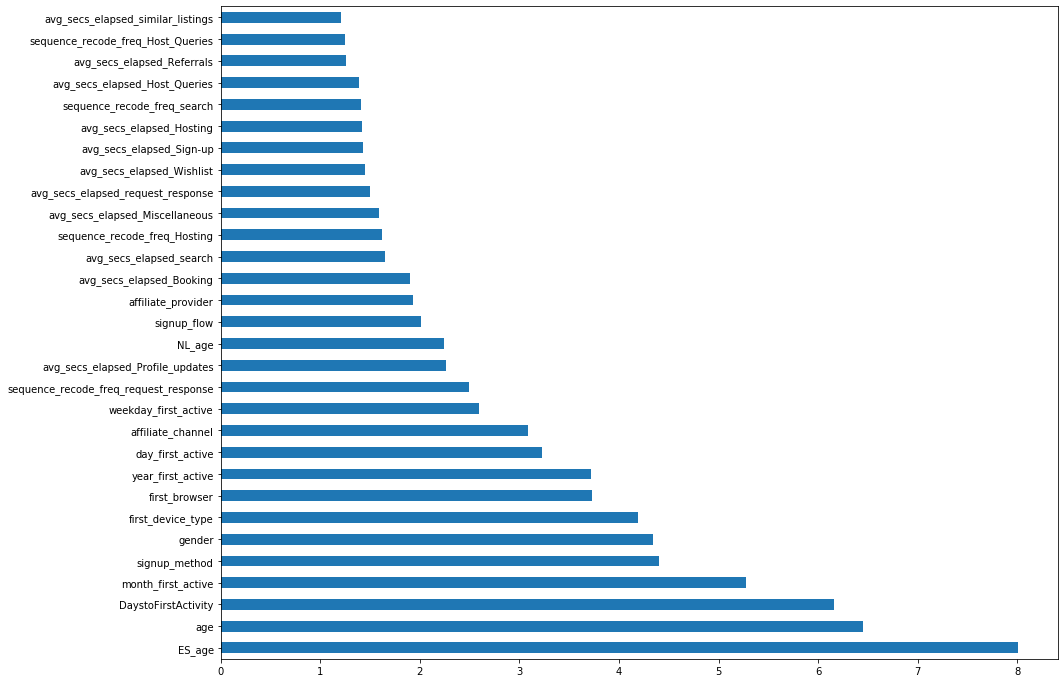

In [0]:
importances = pd.Series(cb_model.feature_importances_, index=x_train.columns)
importances.sort_values(inplace=True, ascending=False)
importances_top30=importances.head(30)
importances_top30.plot(kind='barh',figsize=(15,12))

##### Save CatBoost Model

In [0]:
#save
cb_model.save_model('catboost_model.bin')

In [0]:
#load
cb_model.load_model('catboost_model.bin')
print(cb_model.get_params())
print(cb_model.random_seed_)

{'early_stopping_rounds': 100, 'task_type': 'GPU', 'use_best_model': True, 'random_seed': 1234, 'loss_function': 'MultiClass', 'depth': 7, 'learning_rate': 0.05, 'iterations': 10000, 'od_wait': 100, 'verbose': 0, 'logging_level': 'Silent'}
1234


In [0]:
#pickle save
filename = 'CatBoost_Model1.sav'
pickle.dump(cb_model,open(filename,'wb'))

In [0]:
#pickle load
filename = 'CatBoost_Model1.sav'
cb_model = pickle.load(open(filename,'rb'))
print(cb_model.get_params())
print(cb_model.random_seed_)

{'early_stopping_rounds': 100, 'task_type': 'GPU', 'use_best_model': True, 'random_seed': 1234, 'loss_function': 'MultiClass', 'depth': 7, 'learning_rate': 0.05, 'iterations': 10000, 'od_wait': 100, 'verbose': 0, 'logging_level': 'Silent'}
1234


##### CatBoost Submission file for Kaggle

In [0]:
cb_submission = pd.DataFrame(test_data1['id'],columns= ['id'])

In [0]:
cb_testusers_dest = cb_model.predict_proba(test_data1[cb_modelcolumns])

In [0]:
list(cb_testusers_dest[0])

[0.001220363143837597,
 0.0012736856730755643,
 0.0011278287822841264,
 0.004161141263546421,
 0.011513735686762677,
 0.002659024277227359,
 0.006803218561174668,
 0.7936918981845327,
 0.001410510889903042,
 0.0002803845418372051,
 0.1561996002894918,
 0.019658608706326804]

In [0]:
des = ['AU', 'CA', 'DE', 'ES', 'FR', 'GB', 'IT', 'NDF', 'NL', 'PT', 'US', 'other']


In [0]:
cb_submission['country'] = [sort_list(des,list(cb_testusers_dest[i]))[:5] for i in range(len(test_data1))]

In [0]:
cb_submission = split_data_frame_list(cb_submission,"country")

In [0]:
cb_submission.head(15)

,id,country
0,5uwns89zht,NDF
1,5uwns89zht,US
2,5uwns89zht,other
3,5uwns89zht,FR
4,5uwns89zht,IT
5,jtl0dijy2j,NDF
6,jtl0dijy2j,US
7,jtl0dijy2j,other
8,jtl0dijy2j,FR
9,jtl0dijy2j,IT


In [0]:
cb_submission.to_csv('cb_submission.csv',index = False)

# Model 5 - XGBoost

In [0]:
xgb_modelcolumns = ['gender_OTHER',
 'gender_female',
 'gender_male',
 'signup_method_facebook',
 'signup_method_google',
 'language_ca',
 'language_cs',
 'language_da',
 'language_de',
 'language_el',
 'language_es',
 'language_fi',
 'language_fr',
 'language_hr',
 'language_hu',
 'language_id',
 'language_is',
 'language_it',
 'language_ja',
 'language_ko',
 'language_nl',
 'language_no',
 'language_pl',
 'language_pt',
 'language_ru',
 'language_sv',
 'language_th',
 'language_tr',
 'language_zh',
 'affiliate_channel_api',
 'affiliate_channel_content',
 'affiliate_channel_direct',
 'affiliate_channel_remarketing',
 'affiliate_channel_sem-brand',
 'affiliate_channel_sem-non-brand',
 'affiliate_channel_seo',
 'affiliate_provider_baidu',
 'affiliate_provider_bing',
 'affiliate_provider_craigslist',
 'affiliate_provider_daum',
 'affiliate_provider_direct',
 'affiliate_provider_email-marketing',
 'affiliate_provider_facebook',
 'affiliate_provider_facebook-open-graph',
 'affiliate_provider_google',
 'affiliate_provider_gsp',
 'affiliate_provider_meetup',
 'affiliate_provider_naver',
 'affiliate_provider_padmapper',
 'affiliate_provider_vast',
 'affiliate_provider_wayn',
 'affiliate_provider_yahoo',
 'affiliate_provider_yandex',
 'signup_app_Android',
 'signup_app_Web',
 'signup_app_iOS',
 'first_device_type_Android Phone',
 'first_device_type_Android Tablet',
 'first_device_type_Desktop (Other)',
 'first_device_type_Mac Desktop',
 'first_device_type_SmartPhone (Other)',
 'first_device_type_Windows Desktop',
 'first_device_type_iPad',
 'first_device_type_iPhone',
 'first_browser_Chrome',
 'first_browser_Firefox',
 'first_browser_IE',
 'first_browser_Mobile Safari',
 'first_browser_Others',
 'first_browser_Safari',
 'age',
 'signup_flow',
 'DaystoFirstActivity',
 'day_first_active',
 'weekday_first_active',
 'month_first_active',
 'year_first_active',
 'ES_age',
 'NL_age',
 'Number_of_UniqueDevices',
 'NumberofAppleProducts',
 'NumberofTablets',
 'avg_secs_elapsed_Access',
 'avg_secs_elapsed_Access_bookings',
 'avg_secs_elapsed_Authorization',
 'avg_secs_elapsed_Booking',
 'avg_secs_elapsed_Browse',
 'avg_secs_elapsed_Campaigns',
 'avg_secs_elapsed_Communicate',
 'avg_secs_elapsed_Complaints',
 'avg_secs_elapsed_Errors',
 'avg_secs_elapsed_FAQ',
 'avg_secs_elapsed_Home',
 'avg_secs_elapsed_Host_Queries',
 'avg_secs_elapsed_Hosting',
 'avg_secs_elapsed_Info',
 'avg_secs_elapsed_Info_Cancellation_Refund',
 'avg_secs_elapsed_Listings',
 'avg_secs_elapsed_Miscellaneous',
 'avg_secs_elapsed_Notifications',
 'avg_secs_elapsed_Payment',
 'avg_secs_elapsed_Photography',
 'avg_secs_elapsed_Profile_updates',
 'avg_secs_elapsed_Recommendations',
 'avg_secs_elapsed_Referrals',
 'avg_secs_elapsed_Sign-up',
 'avg_secs_elapsed_Third_party_applications_signup',
 'avg_secs_elapsed_Translate',
 'avg_secs_elapsed_Verification',
 'avg_secs_elapsed_Wishlist',
 'avg_secs_elapsed_new_session',
 'avg_secs_elapsed_request_response',
 'avg_secs_elapsed_reviews',
 'avg_secs_elapsed_search',
 'avg_secs_elapsed_settings',
 'avg_secs_elapsed_similar_listings',
 'avg_secs_elapsed_social',
 'avg_secs_elapsed_view_locations_USA',
 'avg_secs_elapsed_view_locations_general',
 'avg_secs_elapsed_view_locations_topdestination',
 'sequence_recode_freq_Access',
 'sequence_recode_freq_Access_bookings',
 'sequence_recode_freq_Authorization',
 'sequence_recode_freq_Booking',
 'sequence_recode_freq_Booking_confirmation',
 'sequence_recode_freq_Browse',
 'sequence_recode_freq_Campaigns',
 'sequence_recode_freq_Communicate',
 'sequence_recode_freq_Complaints',
 'sequence_recode_freq_Errors',
 'sequence_recode_freq_FAQ',
 'sequence_recode_freq_Home',
 'sequence_recode_freq_Host_Queries',
 'sequence_recode_freq_Hosting',
 'sequence_recode_freq_Info',
 'sequence_recode_freq_Info_Cancellation_Refund',
 'sequence_recode_freq_Listings',
 'sequence_recode_freq_Miscellaneous',
 'sequence_recode_freq_Notifications',
 'sequence_recode_freq_Payment',
 'sequence_recode_freq_Photography',
 'sequence_recode_freq_Profile_updates',
 'sequence_recode_freq_Recommendations',
 'sequence_recode_freq_Referrals',
 'sequence_recode_freq_Sign-up',
 'sequence_recode_freq_Third_party_applications_signup',
 'sequence_recode_freq_Translate',
 'sequence_recode_freq_Verification',
 'sequence_recode_freq_Wishlist',
 'sequence_recode_freq_new_session',
 'sequence_recode_freq_request_response',
 'sequence_recode_freq_reviews',
 'sequence_recode_freq_search',
 'sequence_recode_freq_settings',
 'sequence_recode_freq_social',
 'sequence_recode_freq_view_locations_Europe',
 'sequence_recode_freq_view_locations_USA',
 'sequence_recode_freq_view_locations_general',
 'sequence_recode_freq_view_locations_topdestination',
 'DE_deu',
 'ES_spa',
 'FR_fra',
 'NL_nld']

In [0]:
#Train_test split

X = Data2[xgb_modelcolumns]

# encode Y class values as integers
label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(Data2['country_destination'])
y = label_encoder.transform(Data2['country_destination'])

print(X.shape,y.shape)

x_train, x_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.1, random_state=45, stratify = y)
x_train, x_val, y_train, y_val = model_selection.train_test_split(x_train, y_train, test_size=0.2222, random_state=45, stratify = y_train)

(213451, 163) (213451,)


##### Fit XGBoost

In [0]:
#Creating DMatrix

xgb_train = xgb.DMatrix(x_train,label=y_train)
xgb_val = xgb.DMatrix(x_val,label=y_val)
xgb_test = xgb.DMatrix(x_test,label=y_test)

In [0]:

# train final model on the full data set
params = {
    "eta": 0.05,
    "max_depth": 7, 
    "objective": 'multi:softprob',
    "num_class": 12,
    "subsample": 0.5,
    "colsample_bytree":0.8,
    "colsample_bylevel":0.8,
    "colsample_bynode":0.8,
    "lambda":1,
    "alpha":1
}

xgb_model = xgb.train(params, xgb_train, 1000, evals = [(xgb_val, "val")], verbose_eval=1000,early_stopping_rounds= 100)

[0]	val-merror:0.359251
Will train until val-merror hasn't improved in 100 rounds.
Stopping. Best iteration:
[358]	val-merror:0.349248



In [0]:
xgb_model.best_iteration

358

##### Predict on validation and hold out data

In [0]:
pred_train = xgb_model.predict(xgb_train, ntree_limit=xgb_model.best_ntree_limit)
pred_val = xgb_model.predict(xgb_val, ntree_limit=xgb_model.best_ntree_limit)
pred_test=xgb_model.predict(xgb_test, ntree_limit=xgb_model.best_ntree_limit)

In [0]:
ndcg_score(y_test,pred_test.tolist(),k=5)

0.8303756881214436

In [0]:
des = ['AU', 'CA', 'DE', 'ES', 'FR', 'GB', 'IT', 'NDF', 'NL', 'PT', 'US', 'other']

metrics.accuracy_score(y_test,np.array([sort_list(des,list(pred_test[i]))[:1][0] for i in range(len(y_test))]))

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:182: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


0.0

In [0]:
y_test[:5]

array([ 7,  7, 10, 10,  7])

array(['US', 'NDF', 'NDF', ..., 'US', 'NDF', 'NDF'], dtype='<U5')

##### Model Interpretation

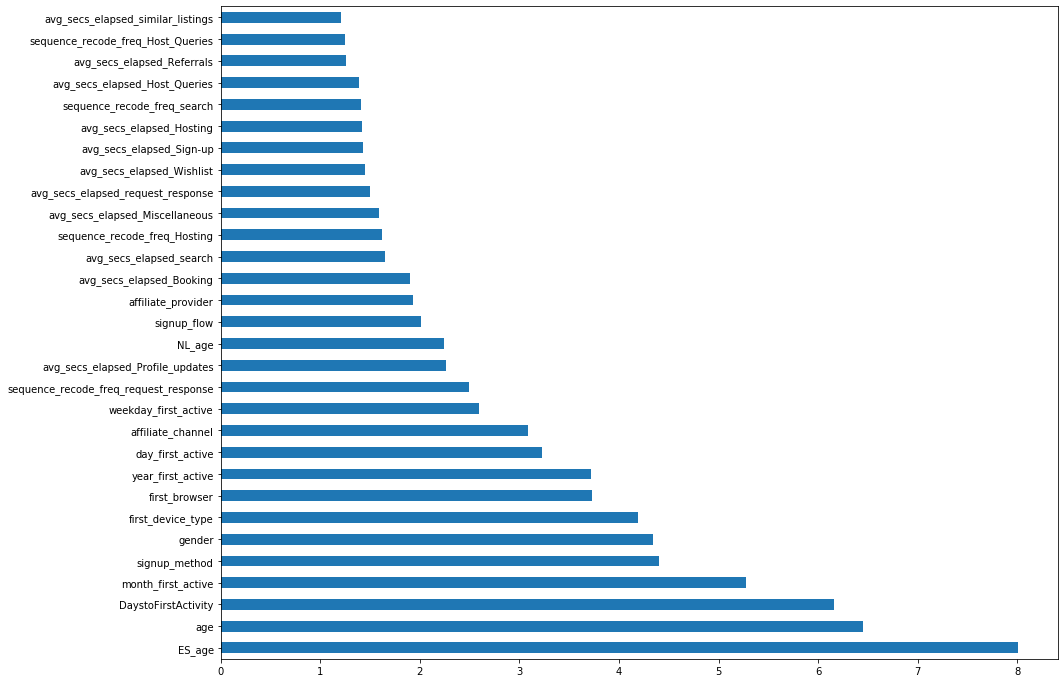

In [0]:
xgb_importances = pd.Series(xgb_model.get_score(importance_type='gain'))
xgb_importances.sort_values(inplace=True, ascending=False)
xgb_importances_top30=importances.head(30)
xgb_importances_top30.plot(kind='barh',figsize=(15,12))

##### Save XGBoost Model

In [0]:
#save
xgb_model.save_model('XGBoost.model')

In [0]:
#load
xgb_model.load_model('XGBoost.model')

In [0]:
#pickle save
filename1 = 'XGBoost_model1.sav'
pickle.dump(xgb_model,open(filename1,'wb'))


In [0]:
#picke load
filename1 = 'XGBoost_model1.sav'
xgb_model = pickle.load(open(filename1,'rb'))

##### XGBoost Submission file for Kaggle

In [0]:
xgb_submission = pd.DataFrame(test_data2['id'],columns= ['id'])

In [0]:
xgb_testusers = xgb.DMatrix(test_data2[xgb_modelcolumns])

In [0]:
xgb_testusers_dest = xgb_model.predict(xgb_testusers)

In [0]:
list(xgb_testusers_dest[0])

[0.0022854388,
 0.0031178382,
 0.0014419473,
 0.0060034543,
 0.016015923,
 0.0022901923,
 0.013916282,
 0.6357164,
 0.0049265944,
 0.00037333058,
 0.2814997,
 0.032412905]

In [0]:
des = ['AU', 'CA', 'DE', 'ES', 'FR', 'GB', 'IT', 'NDF', 'NL', 'PT', 'US', 'other']


In [0]:
xgb_submission['country'] = [sort_list(des,list(xgb_testusers_dest[i]))[:5] for i in range(len(test_data2))]

In [0]:
xgb_submission = split_data_frame_list(xgb_submission,"country")

In [0]:
xgb_submission.head(15)

,id,country
0,5uwns89zht,NDF
1,5uwns89zht,US
2,5uwns89zht,other
3,5uwns89zht,FR
4,5uwns89zht,IT
5,jtl0dijy2j,NDF
6,jtl0dijy2j,US
7,jtl0dijy2j,other
8,jtl0dijy2j,FR
9,jtl0dijy2j,IT


In [0]:
xgb_submission.to_csv('xgb_submission.csv',index = False)

# Model 6 - LightGBM

## Basic Model - LightGBM with default boosting machanism (‘gbdt’, traditional Gradient Boosting Decision Tree)

### Train_test_split

In [0]:
#Use same columns and Train_test split as XGBoost

In [0]:
train_data = lgb.Dataset(x_train,label=y_train)
val_data = lgb.Dataset(x_val,label=y_val)
test_data = lgb.Dataset(x_test,label=y_test)

In [0]:
#Change parameters as per your problem

param = {'num_leaves':150, 'objective':'multiclass','num_class':12,'max_depth':7,'learning_rate':0.05,'max_bin':200,'feature_fraction':0.8,'feature_fraction_bynode':0.8,'metric':'multi_logloss'}

##### Fit LightGBM

In [0]:
#training our model using light gbm

lgb_model=lgb.train(param,train_data,valid_sets=val_data,early_stopping_rounds=100,num_boost_round=1000,verbose_eval=True)

In [0]:
lgb_model.best_iteration

180

##### Predict on validation and hold out data

In [0]:
lgb_pred_train= lgb_model.predict(x_train)
lgb_pred_val = lgb_model.predict(x_val)
lgb_pred_test = lgb_model.predict(x_test)

In [0]:
type(lgb_pred_test.tolist())

list

##### NDCG

In [0]:
ndcg_score(list(y_test),lgb_pred_test.tolist(),k=5)

0.8306255284817483

##### Model Interpretation

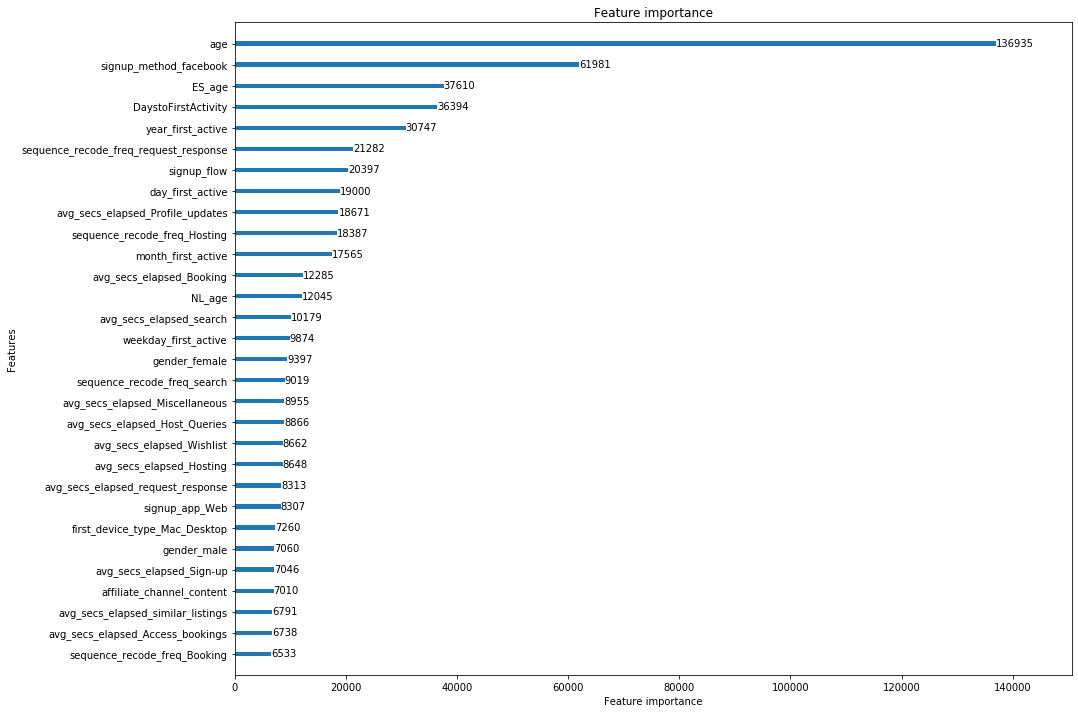

In [0]:
lgb.plot_importance(lgb_model, importance_type='gain', max_num_features=30, ignore_zero=True, figsize=(15,12), grid=False,precision=0)

##### Save LightGBM Model

In [0]:
#pickle save
filename = 'LightGBM_Model1.sav'
pickle.dump(lgb_model,open(filename,'wb'))

In [0]:
#pickle load

lgb_model = pickle.load(open(filename,'rb'))

###### **LightGBM** Submission file for Kaggle

In [0]:
lgb_submission = pd.DataFrame(test_data2['id'],columns= ['id'])

In [0]:
lgb_testusers_dest = lgb_model.predict(test_data2[xgb_modelcolumns])

In [0]:
list(lgb_testusers_dest[0])

[0.004610022067355215,
 0.0008600779059277376,
 0.0009353936247777181,
 0.0037480125238900804,
 0.00896807006526344,
 0.002243774866927664,
 0.004782592625958657,
 0.7885059195405317,
 0.006819149123165922,
 0.0002875088891697721,
 0.15166377399381648,
 0.026575704773215518]

In [0]:
des = ['AU', 'CA', 'DE', 'ES', 'FR', 'GB', 'IT', 'NDF', 'NL', 'PT', 'US', 'other']


In [0]:
lgb_submission['country'] = [sort_list(des,list(lgb_testusers_dest[i]))[:5] for i in range(len(test_data2))]

In [0]:
lgb_submission = split_data_frame_list(lgb_submission,"country")

In [0]:
lgb_submission.head(15)

,id,country
0,5uwns89zht,NDF
1,5uwns89zht,US
2,5uwns89zht,other
3,5uwns89zht,FR
4,5uwns89zht,NL
5,jtl0dijy2j,NDF
6,jtl0dijy2j,US
7,jtl0dijy2j,other
8,jtl0dijy2j,FR
9,jtl0dijy2j,IT


In [0]:
lgb_submission.to_csv('lgb_submission.csv',index = False)

## Basic Model - LightGBM model with dart boosting mechanism


### Train_test_split

In [0]:
#Use same columns and Train_test split as XGBoost

In [0]:
train_data = lgb.Dataset(x_train,label=y_train)
val_data = lgb.Dataset(x_val,label=y_val)
test_data = lgb.Dataset(x_test,label=y_test)

In [0]:
#Change parameters as per your problem

param = {'boosting':'dart', 'num_leaves':150, 'objective':'multiclass','num_class':12,'max_depth':7,'learning_rate':0.05,'max_bin':200,'feature_fraction':0.8,'feature_fraction_bynode':0.8,'metric':'multi_logloss'}

##### Fit LightGBM

In [0]:
#training our model using light gbm

lgb_model_dart=lgb.train(param,train_data,valid_sets=val_data,early_stopping_rounds=100,num_boost_round=1000,verbose_eval=True)

[1]	valid_0's multi_logloss: 1.15394


/usr/local/lib/python3.6/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[2]	valid_0's multi_logloss: 1.14574
[3]	valid_0's multi_logloss: 1.13859
[4]	valid_0's multi_logloss: 1.13152
[5]	valid_0's multi_logloss: 1.12541
[6]	valid_0's multi_logloss: 1.11946
[7]	valid_0's multi_logloss: 1.11425
[8]	valid_0's multi_logloss: 1.1164
[9]	valid_0's multi_logloss: 1.11127
[10]	valid_0's multi_logloss: 1.10642
[11]	valid_0's multi_logloss: 1.10273
[12]	valid_0's multi_logloss: 1.10415
[13]	valid_0's multi_logloss: 1.09986
[14]	valid_0's multi_logloss: 1.09595
[15]	valid_0's multi_logloss: 1.09213
[16]	valid_0's multi_logloss: 1.08879
[17]	valid_0's multi_logloss: 1.0855
[18]	valid_0's multi_logloss: 1.08259
[19]	valid_0's multi_logloss: 1.0798
[20]	valid_0's multi_logloss: 1.07724
[21]	valid_0's multi_logloss: 1.07799
[22]	valid_0's multi_logloss: 1.07545
[23]	valid_0's multi_logloss: 1.07327
[24]	valid_0's multi_logloss: 1.07117
[25]	valid_0's multi_logloss: 1.06902
[26]	valid_0's multi_logloss: 1.06708
[27]	valid_0's multi_logloss: 1.06545
[28]	valid_0's multi_lo

In [0]:
lgb_model_dart.best_iteration

0

##### Predict on validation and hold out data

In [0]:
lgb_pred_train_dart= lgb_model_dart.predict(x_train)
lgb_pred_val_dart = lgb_model_dart.predict(x_val)
lgb_pred_test_dart = lgb_model_dart.predict(x_test)

In [0]:
type(lgb_pred_test_dart.tolist())

list

##### NDCG

In [0]:
ndcg_score(list(y_test),lgb_pred_test_dart.tolist(),k=5)

0.8312712724075695

##### Model Interpretation

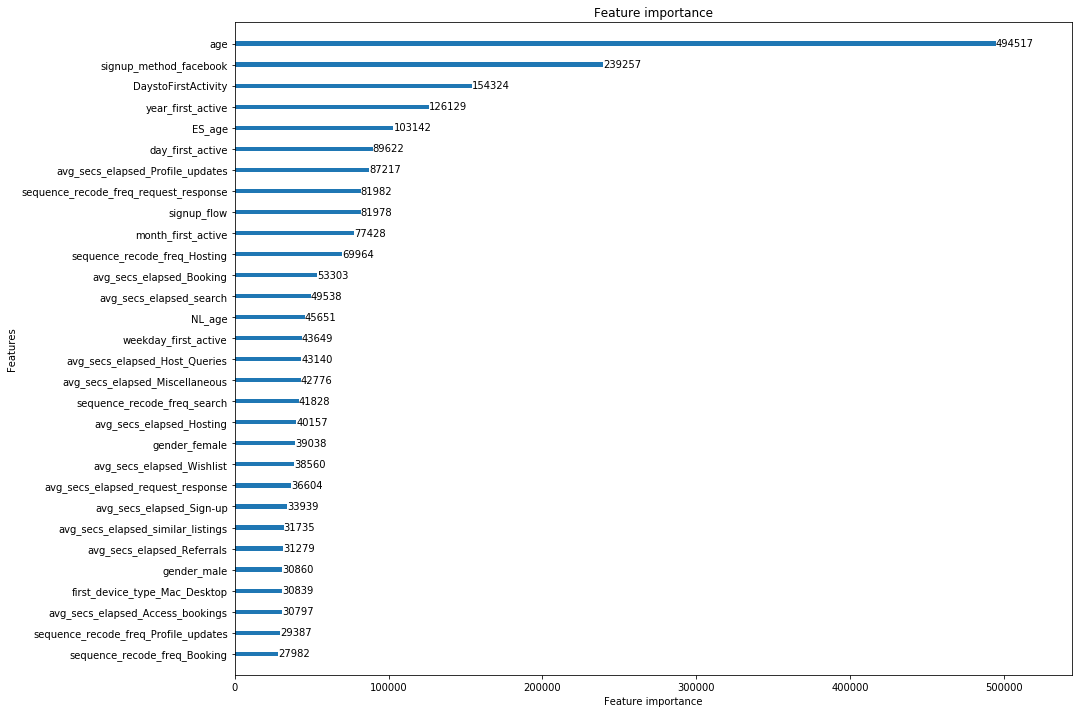

In [0]:
lgb.plot_importance(lgb_model_dart, importance_type='gain', max_num_features=30, ignore_zero=True, figsize=(15,12), grid=False,precision=0)

##### Save LightGBM Model

In [0]:
#pickle save
filename = 'LightGBM_Model_dart.sav'
pickle.dump(lgb_model_dart,open(filename,'wb'))

In [0]:
#pickle load

lgb_model_dart = pickle.load(open(filename,'rb'))

###### **LightGBM_dart** Submission file for Kaggle

In [0]:
lgb_submission_dart = pd.DataFrame(test_data2['id'],columns= ['id'])

In [0]:
lgb_testusers_dest_dart = lgb_model_dart.predict(test_data2[xgb_modelcolumns])

In [0]:
list(lgb_testusers_dest_dart[0])

[0.002727425453778127,
 0.0011223327519783645,
 0.001341689547992798,
 0.005196097118462765,
 0.012211938889286266,
 0.002412273508868447,
 0.006749614707432381,
 0.779766136507409,
 0.006116120318610004,
 0.00031005482885506296,
 0.15383525032249742,
 0.028211066044829376]

In [0]:
des = ['AU', 'CA', 'DE', 'ES', 'FR', 'GB', 'IT', 'NDF', 'NL', 'PT', 'US', 'other']


In [0]:
lgb_submission_dart['country'] = [sort_list(des,list(lgb_testusers_dest_dart[i]))[:5] for i in range(len(test_data2))]

In [0]:
lgb_submission_dart = split_data_frame_list(lgb_submission_dart,"country")

In [0]:
lgb_submission_dart.head(15)

,id,country
0,5uwns89zht,NDF
1,5uwns89zht,US
2,5uwns89zht,other
3,5uwns89zht,FR
4,5uwns89zht,IT
5,jtl0dijy2j,NDF
6,jtl0dijy2j,US
7,jtl0dijy2j,other
8,jtl0dijy2j,FR
9,jtl0dijy2j,IT


In [0]:
lgb_submission_dart.to_csv('lgb_submission_dart.csv',index = False)

## LGBM Parameter Tuning

In [0]:
#Parameter tuning

#objective
objective = 'multiclass'
num_class = 12

#max_bin
max_bin = [200,255]

# Learning rate
learning_rate = [0.01,0.1]

# number of leaves
num_leaves = [100,200,300]

#Boosting type
boosting = ['gbdt','dart', 'goss']

# Maximum number of levels in tree
max_depth = [-1,10,20]

#Feature fraction
feature_fraction = [0.4,0.6,0.8]
feature_fraction_bynode = [0.6,0.8]

# Number of iterations
num_iterations = [100,200]

# Minimum number of samples required at each leaf node
min_data_in_leaf = [100,500]

# metric
metric = 'multi_logloss'

# Create the random grid
random_grid = {
               'max_bin':max_bin,
               'learning_rate':learning_rate,
               'num_leaves':num_leaves,
               'max_depth':max_depth,
               'boosting':boosting,
               'max_depth': max_depth,
               'feature_fraction':feature_fraction,
               'feature_fraction_bynode':feature_fraction_bynode,
               'num_iterations':num_iterations,
               'min_data_in_leaf': min_data_in_leaf,
               }

print(random_grid)

{'max_bin': [200, 255], 'learning_rate': [0.01, 0.1], 'num_leaves': [100, 200, 300], 'max_depth': [-1, 10, 20], 'boosting': ['gbdt', 'dart', 'goss'], 'feature_fraction': [0.4, 0.6, 0.8], 'feature_fraction_bynode': [0.6, 0.8], 'num_iterations': [100, 200], 'min_data_in_leaf': [100, 500]}


In [0]:
# First create the base model to tune

lgb_tune = lgb.LGBMClassifier(objective = 'multiclass',num_class = 12,metric = 'multi_logloss')

# Random search of parameters, using 3 fold cross validation, 
# search across 10 different combinations

lgb_random = RandomizedSearchCV(estimator = lgb_tune, param_distributions = random_grid, n_iter = 10, cv = 3, verbose=30, random_state=45, n_jobs = -1, scoring='accuracy')

# Fit the random search model

lgb_random.fit(x_val,y_val)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   38.9s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   38.9s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:  3.9min
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=LGBMClassifier(boosting_type='gbdt',
                                            class_weight=None,
                                            colsample_bytree=1.0,
                                            importance_type='split',
                                            learning_rate=0.1, max_depth=-1,
                                            metric='multi_logloss',
                                            min_child_samples=20,
                                            min_child_weight=0.001,
                                            min_split_gain=0.0,
                                            n_estimators=100, n_jobs=-1,
                                            num_class=12, num_leaves=31,
                                            objective='mul...
                   param_distributions={'boosting': ['gbdt', 'dart', 'goss'],
                                        'feature_

In [0]:
lgb_random.best_estimator_

LGBMClassifier(boosting='gbdt', boosting_type='gbdt', class_weight=None,
               colsample_bytree=1.0, feature_fraction=0.6,
               feature_fraction_bynode=0.6, importance_type='split',
               learning_rate=0.1, max_bin=200, max_depth=10,
               metric='multi_logloss', min_child_samples=20,
               min_child_weight=0.001, min_data_in_leaf=100, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_class=12, num_iterations=200,
               num_leaves=300, objective='multiclass', random_state=None,
               reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

In [0]:
lgb_random.best_score_

0.6466991519467741

## Model 6: LGBM ('gbdt') Tuned Model 

In [0]:
#Change parameters as per your problem

param = {
         'objective':'multiclass','num_class':12,'max_depth':10,'learning_rate':0.1,'max_bin':200,'feature_fraction':0.6,'feature_fraction_bynode':0.6,'metric':'multi_logloss',
         'min_data_in_leaf': 100, 'num_iterations': 200, 'num_leaves':300
         }


In [0]:
lgb_tuned = lgb.train(param, train_set=train_data,valid_sets=val_data,early_stopping_rounds=100,num_boost_round=200,verbose_eval=True)

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's multi_logloss: 1.14635
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's multi_logloss: 1.13274
[3]	valid_0's multi_logloss: 1.1194
[4]	valid_0's multi_logloss: 1.10873
[5]	valid_0's multi_logloss: 1.09967
[6]	valid_0's multi_logloss: 1.09165
[7]	valid_0's multi_logloss: 1.08416
[8]	valid_0's multi_logloss: 1.0778
[9]	valid_0's multi_logloss: 1.07249
[10]	valid_0's multi_logloss: 1.06768
[11]	valid_0's multi_logloss: 1.06471
[12]	valid_0's multi_logloss: 1.06101
[13]	valid_0's multi_logloss: 1.0577
[14]	valid_0's multi_logloss: 1.05484
[15]	valid_0's multi_logloss: 1.05255
[16]	valid_0's multi_logloss: 1.05026
[17]	valid_0's multi_logloss: 1.04892
[18]	valid_0's multi_logloss: 1.04693
[19]	valid_0's multi_logloss: 1.0454
[20]	valid_0's multi_logloss: 1.04384
[21]	valid_0's multi_logloss: 1.04256
[22]	valid_0's multi_logloss: 1.04139
[23]	valid_0's multi_logloss: 1.04039
[24]	valid_0's multi_logloss: 1.03952
[25]	valid_0's multi_logloss: 1.03869


##### Predict on validation and hold out data

In [0]:
lgb_pred_train = lgb_tuned.predict(x_train)
lgb_pred_val = lgb_tuned.predict(x_val)
lgb_pred_test = lgb_tuned.predict(x_test)

##### NDCG

In [0]:
ndcg_score(list(y_test),lgb_pred_test.tolist(),k=5)

0.8310034929710983

##### Model Interpretation

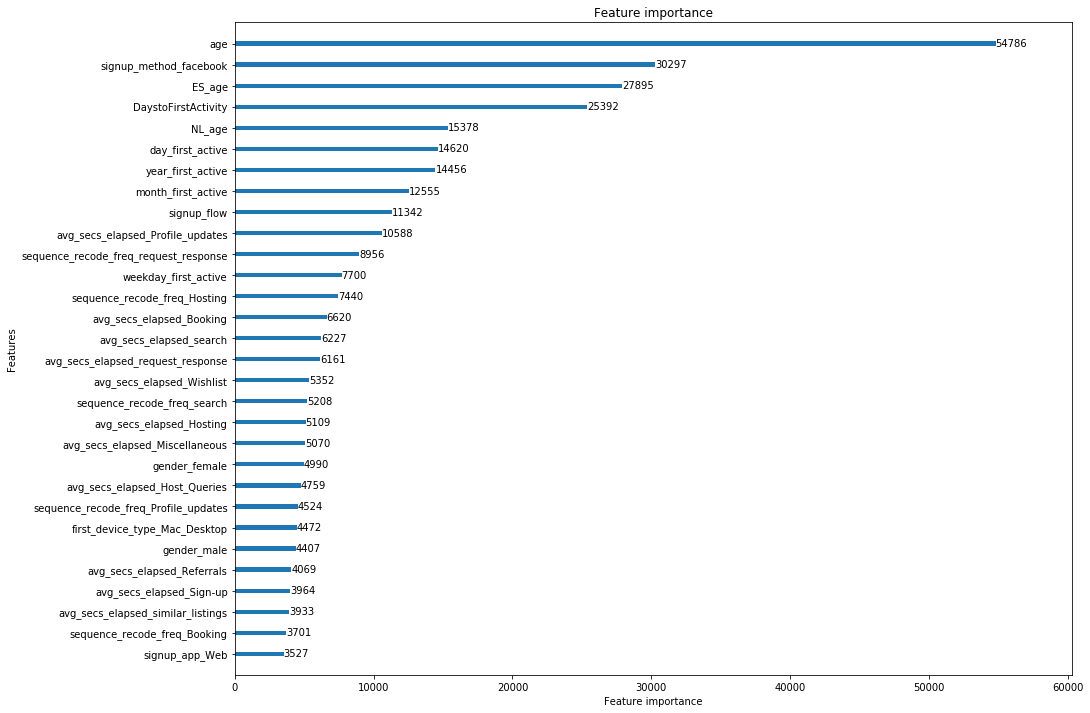

In [0]:
lgb.plot_importance(lgb_tuned, importance_type='gain', max_num_features=30, ignore_zero=True, figsize=(15,12), grid=False,precision=0)

##### Save LightGBM Model

In [0]:
#pickle save
filename = 'LightGBM_Model_gbdt_tuned.sav'
pickle.dump(lgb_tuned,open(filename,'wb'))

In [0]:
#pickle load

lgb_model = pickle.load(open(filename,'rb'))

###### **LightGBM_dart** Submission file for Kaggle

In [0]:
lgb_submission_gbdt_tuned = pd.DataFrame(test_data2['id'],columns= ['id'])

In [0]:
lgb_testusers_dest_gbdt_tuned = lgb_tuned.predict(test_data2[xgb_modelcolumns])

In [0]:
list(lgb_testusers_dest_gbdt_tuned[0])

[0.0047727524042081495,
 0.0011665869276734442,
 0.002052704886245983,
 0.0054367181628943015,
 0.010130826818590495,
 0.0031425597890402186,
 0.009535435815492082,
 0.702479046803966,
 0.0032926246327589577,
 0.0009992205144720996,
 0.2186518779559609,
 0.03833964528869742]

In [0]:
des = ['AU', 'CA', 'DE', 'ES', 'FR', 'GB', 'IT', 'NDF', 'NL', 'PT', 'US', 'other']


In [0]:
lgb_submission_gbdt_tuned['country'] = [sort_list(des,list(lgb_testusers_dest_gbdt_tuned[i]))[:5] for i in range(len(test_data2))]

In [0]:
lgb_submission_gbdt_tuned = split_data_frame_list(lgb_submission_gbdt_tuned,"country")

In [0]:
lgb_submission_gbdt_tuned.head(15)

,id,country
0,5uwns89zht,NDF
1,5uwns89zht,US
2,5uwns89zht,other
3,5uwns89zht,FR
4,5uwns89zht,IT
5,jtl0dijy2j,NDF
6,jtl0dijy2j,US
7,jtl0dijy2j,other
8,jtl0dijy2j,IT
9,jtl0dijy2j,FR


In [0]:
lgb_submission_gbdt_tuned.to_csv('lgb_submission_gbdt_tuned.csv',index = False)

## Model 6.1: LGB Tuned Model - using the tuned parameters with 'dart' boosting mechanism

In [0]:
#Change parameters as per your problem

param = {
         'boosting':'dart', 'objective':'multiclass','num_class':12,'max_depth':10,'learning_rate':0.1,'max_bin':200,'feature_fraction':0.6,'feature_fraction_bynode':0.6,'metric':'multi_logloss',
         'min_data_in_leaf': 500, 'num_iterations': 200, 'num_leaves':300
         #,'boosting_type':'goss'
         }

In [0]:
lgb_tuned = lgb.train(param, train_set=train_data,valid_sets=val_data,early_stopping_rounds=100,num_boost_round=200,verbose_eval=True)

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's multi_logloss: 1.14687


/usr/local/lib/python3.6/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[2]	valid_0's multi_logloss: 1.13366
[3]	valid_0's multi_logloss: 1.12085
[4]	valid_0's multi_logloss: 1.11048
[5]	valid_0's multi_logloss: 1.10169
[6]	valid_0's multi_logloss: 1.09395
[7]	valid_0's multi_logloss: 1.08654
[8]	valid_0's multi_logloss: 1.08914
[9]	valid_0's multi_logloss: 1.08278
[10]	valid_0's multi_logloss: 1.07706
[11]	valid_0's multi_logloss: 1.07357
[12]	valid_0's multi_logloss: 1.075
[13]	valid_0's multi_logloss: 1.07043
[14]	valid_0's multi_logloss: 1.06631
[15]	valid_0's multi_logloss: 1.06297
[16]	valid_0's multi_logloss: 1.05972
[17]	valid_0's multi_logloss: 1.05797
[18]	valid_0's multi_logloss: 1.0552
[19]	valid_0's multi_logloss: 1.05302
[20]	valid_0's multi_logloss: 1.05092
[21]	valid_0's multi_logloss: 1.05168
[22]	valid_0's multi_logloss: 1.04984
[23]	valid_0's multi_logloss: 1.04823
[24]	valid_0's multi_logloss: 1.04679
[25]	valid_0's multi_logloss: 1.04542
[26]	valid_0's multi_logloss: 1.04424
[27]	valid_0's multi_logloss: 1.04325
[28]	valid_0's multi_lo

##### Predict on validation and hold out data

In [0]:
lgb_pred_train_dart= lgb_tuned.predict(x_train)
lgb_pred_val_dart = lgb_tuned.predict(x_val)
lgb_pred_test_dart = lgb_tuned.predict(x_test)

In [0]:
type(lgb_pred_test_dart.tolist())

list

##### NDCG

In [0]:
ndcg_score(list(y_test),lgb_pred_test_dart.tolist(),k=5)

0.8314432574551636

##### Model Interpretation

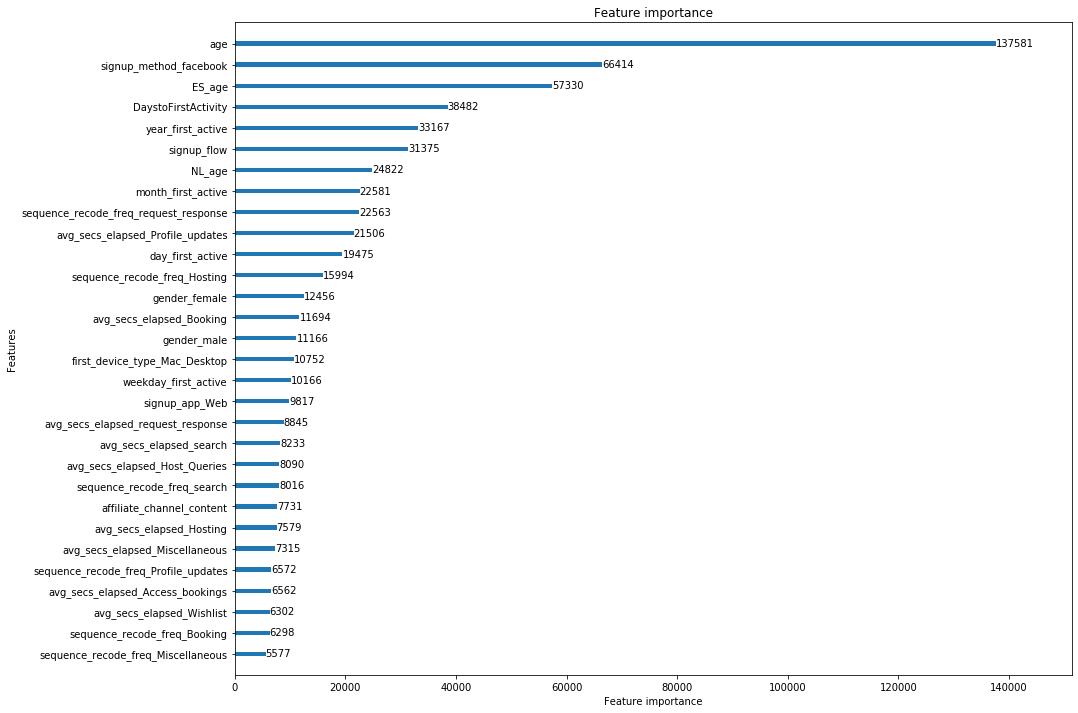

In [0]:
lgb.plot_importance(lgb_tuned, importance_type='gain', max_num_features=30, ignore_zero=True, figsize=(15,12), grid=False,precision=0)

##### Save LightGBM Model

In [0]:
#pickle save
filename = 'LightGBM_Model_dart_tuned.sav'
pickle.dump(lgb_tuned,open(filename,'wb'))

In [0]:
#pickle load

lgb_model_dart = pickle.load(open(filename,'rb'))

###### **LightGBM_dart_tuned** Submission file for Kaggle

In [0]:
lgb_submission_dart_tuned = pd.DataFrame(test_data2['id'],columns= ['id'])

In [0]:
lgb_testusers_dest_dart_tuned = lgb_tuned.predict(test_data2[xgb_modelcolumns])

In [0]:
list(lgb_testusers_dest_dart_tuned[0])

[0.0065161790008283005,
 0.0036279389519621188,
 0.004481311742526199,
 0.008311832534120867,
 0.014631807329932661,
 0.006745878909769904,
 0.011673980579199444,
 0.7334499678898856,
 0.00763882046317984,
 0.0031692190909037555,
 0.16560748765090985,
 0.03414557585678156]

In [0]:
des = ['AU', 'CA', 'DE', 'ES', 'FR', 'GB', 'IT', 'NDF', 'NL', 'PT', 'US', 'other']


In [0]:
lgb_submission_dart_tuned['country'] = [sort_list(des,list(lgb_testusers_dest_dart_tuned[i]))[:5] for i in range(len(test_data2))]

In [0]:
lgb_submission_dart_tuned = split_data_frame_list(lgb_submission_dart_tuned,"country")

In [0]:
lgb_submission_dart_tuned.head(15)

,id,country
0,5uwns89zht,NDF
1,5uwns89zht,US
2,5uwns89zht,other
3,5uwns89zht,FR
4,5uwns89zht,IT
5,jtl0dijy2j,NDF
6,jtl0dijy2j,US
7,jtl0dijy2j,other
8,jtl0dijy2j,IT
9,jtl0dijy2j,FR


In [0]:
lgb_submission_dart_tuned.to_csv('lgb_submission_dart_tuned.csv',index = False)

## Model 6.2: LGB Tuned Model - using the tuned parameters with 'goss' boosting mechanism

In [0]:
#Change parameters as per your problem

param = {
         'boosting':'goss', 'objective':'multiclass','num_class':12,'max_depth':10,'learning_rate':0.1,'max_bin':200,'feature_fraction':0.6,'feature_fraction_bynode':0.6,'metric':'multi_logloss',
         'min_data_in_leaf': 500, 'num_iterations': 200, 'num_leaves':300
         }

In [0]:
lgb_tuned = lgb.train(param, train_set=train_data,valid_sets=val_data,early_stopping_rounds=100,num_boost_round=1000,verbose_eval=True)

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's multi_logloss: 1.14687
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's multi_logloss: 1.13366
[3]	valid_0's multi_logloss: 1.12085
[4]	valid_0's multi_logloss: 1.11048
[5]	valid_0's multi_logloss: 1.10169
[6]	valid_0's multi_logloss: 1.09395
[7]	valid_0's multi_logloss: 1.08654
[8]	valid_0's multi_logloss: 1.08024
[9]	valid_0's multi_logloss: 1.07502
[10]	valid_0's multi_logloss: 1.07036
[11]	valid_0's multi_logloss: 1.06826
[12]	valid_0's multi_logloss: 1.06519
[13]	valid_0's multi_logloss: 1.06247
[14]	valid_0's multi_logloss: 1.05997
[15]	valid_0's multi_logloss: 1.05817
[16]	valid_0's multi_logloss: 1.05618
[17]	valid_0's multi_logloss: 1.05516
[18]	valid_0's multi_logloss: 1.05348
[19]	valid_0's multi_logloss: 1.05221
[20]	valid_0's multi_logloss: 1.05094
[21]	valid_0's multi_logloss: 1.04993
[22]	valid_0's multi_logloss: 1.04876
[23]	valid_0's multi_logloss: 1.04785
[24]	valid_0's multi_logloss: 1.04721
[25]	valid_0's multi_logloss: 1.04

##### Predict on validation and hold out data

In [0]:
lgb_pred_train_goss= lgb_tuned.predict(x_train)
lgb_pred_val_goss = lgb_tuned.predict(x_val)
lgb_pred_test_goss = lgb_tuned.predict(x_test)

##### NDCG

In [0]:
ndcg_score(list(y_test),lgb_pred_test_goss.tolist(),k=5)

0.829814928263704

##### Model Interpretation

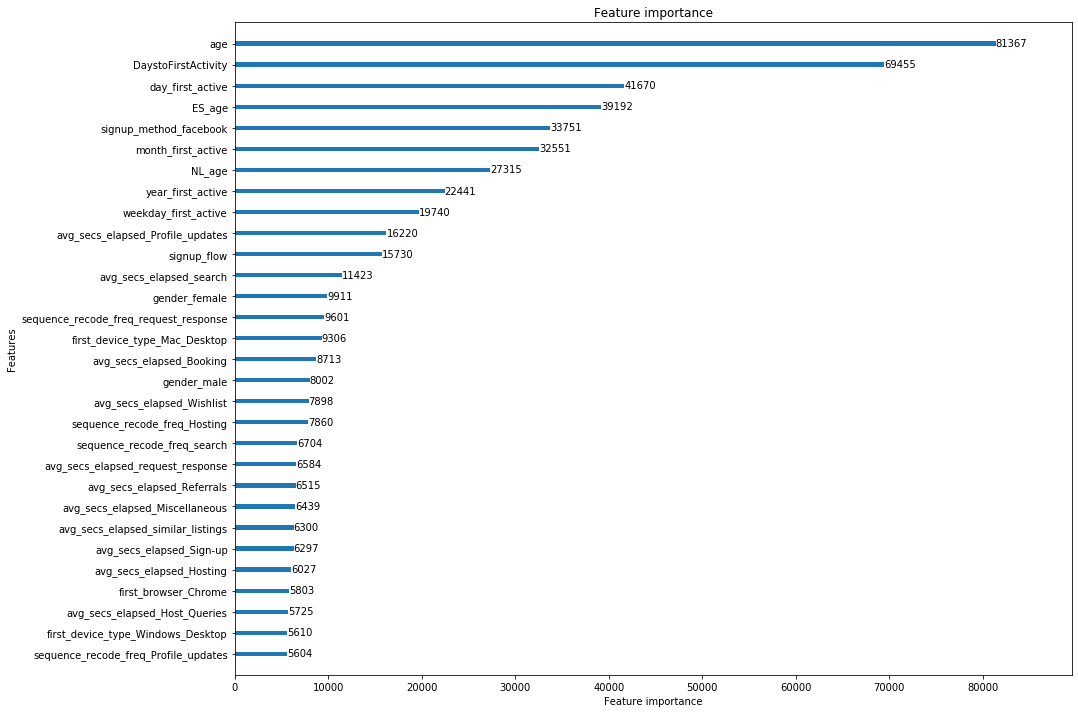

In [0]:
lgb.plot_importance(lgb_tuned, importance_type='gain', max_num_features=30, ignore_zero=True, figsize=(15,12), grid=False,precision=0)

##### Save LightGBM Model

In [0]:
#pickle save
filename = 'LightGBM_Model_goss_tuned.sav'
pickle.dump(lgb_tuned,open(filename,'wb'))

In [0]:
#pickle load

lgb_model_dart = pickle.load(open(filename,'rb'))

###### **LightGBM_goss_tuned** Submission file for Kaggle

In [0]:
lgb_submission_goss_tuned = pd.DataFrame(test_data2['id'],columns= ['id'])

In [0]:
lgb_testusers_dest_goss_tuned = lgb_tuned.predict(test_data2[xgb_modelcolumns])

In [0]:
list(lgb_testusers_dest_goss_tuned[0])

[0.010632048086244055,
 0.0020837426264347144,
 0.0015627517159877982,
 0.003906701173799135,
 0.012373029571960093,
 0.002102469212392826,
 0.007343637084634953,
 0.7876495674706984,
 0.0022522345805421943,
 0.0004101020950175456,
 0.14941125526904722,
 0.020272461113241314]

In [0]:
des = ['AU', 'CA', 'DE', 'ES', 'FR', 'GB', 'IT', 'NDF', 'NL', 'PT', 'US', 'other']


In [0]:
lgb_submission_goss_tuned['country'] = [sort_list(des,list(lgb_testusers_dest_goss_tuned[i]))[:5] for i in range(len(test_data2))]

In [0]:
lgb_submission_goss_tuned = split_data_frame_list(lgb_submission_goss_tuned,"country")

In [0]:
lgb_submission_goss_tuned.head(15)

,id,country
0,5uwns89zht,NDF
1,5uwns89zht,US
2,5uwns89zht,other
3,5uwns89zht,FR
4,5uwns89zht,AU
5,jtl0dijy2j,NDF
6,jtl0dijy2j,US
7,jtl0dijy2j,other
8,jtl0dijy2j,FR
9,jtl0dijy2j,IT


In [0]:
lgb_submission_goss_tuned.to_csv('lgb_submission_goss_tuned.csv',index = False)